In [65]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import transformers
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from math import sqrt
import scipy.stats as stats
tokenizer_deep = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased")

D:\MY_PROGRAMMIER_SLOTS\anaconda3\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [2]:
class BertRegression(nn.Module):
    def __init__(self, model_name="DeepPavlov/rubert-base-cased",
                 pretrained_weights_path="destination_filename.pth", device = 'cpu'):

        super(BertRegression, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)  # Предобученная модель BERT
        self.dropout = torch.nn.Dropout(0.2)  # Регуляризация
        self.layer_norm = nn.LayerNorm(self.bert.config.hidden_size)  # Добавление Layer Normalization
        self.regressor = nn.Sequential(
            nn.Linear(self.bert.config.hidden_size, 256),
            nn.Tanh(),
            nn.Linear(256, 1)
        )
        self.load_state_dict(
            torch.load(pretrained_weights_path,
                       map_location=torch.device('cpu'),
                       weights_only=True))
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        dropout_output = self.dropout(pooled_output)
        layer_norm_output = self.layer_norm(dropout_output)
        linear_output = self.regressor(layer_norm_output)
        return linear_output 

In [46]:
device = 'cuda'
bert_regression_model = BertRegression(device=device, pretrained_weights_path='bertweight2new2.pth')
bert_regression_model.to(device)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertRegression(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [6]:
df = pd.read_csv('testbert1.csv')
df
#score_gpt это предсказания модели, HF это разметка человека 

,message,timestamp,sentiment_level,sentiment_score_gpt,sentiment_HF
0,sudo apt install postgresqlplpython\nя себе на...,2024-09-08 8:31:05,Neutral,0.70,0.30
1,sergeysavinovv,2024-09-07 12:13:38,Neutral,0.00,0.00
2,postgresql on x_pclinuxgnu compiled by gcc de...,2024-09-07 12:13:33,Neutral,0.00,0.00
3,какая версия postgresql,2024-09-07 9:09:05,Neutral,0.00,0.00
4,да,2024-09-05 15:02:36,Neutral,0.00,0.00
...,...,...,...,...,...
159,я ливаю нафиг,2024-09-03 10:24:40,Negative,-0.80,-0.70
160,я устал блин уже,2024-09-03 10:24:36,Mildly Negative,-0.04,-0.04
161,курс кал собачий,2024-09-03 10:22:31,Highly Negative,-0.80,-0.80
162,это какой то пиздец,2024-09-03 10:22:25,Highly Negative,-0.90,-0.90


In [34]:
df['sentiment_score_gpt'].describe()

count    164.000000
mean       0.039512
std        0.560223
min       -1.000000
25%       -0.140000
50%        0.000000
75%        0.600000
max        1.000000
Name: sentiment_score_gpt, dtype: float64

In [33]:
df['sentiment_HF'].describe()

count    164.000000
mean       0.050976
std        0.476600
min       -1.000000
25%       -0.100000
50%        0.000000
75%        0.545000
max        1.000000
Name: sentiment_HF, dtype: float64

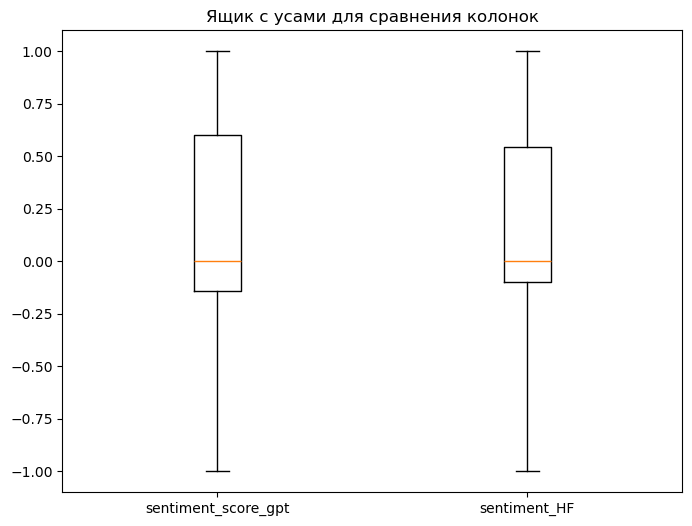

In [21]:
#Сравниваем GPT и HF распределение
plt.figure(figsize=(8, 6))
plt.boxplot([df['sentiment_score_gpt'], df['sentiment_HF']], labels=['sentiment_score_gpt', 'sentiment_HF'])
plt.title('Ящик с усами')
plt.show()

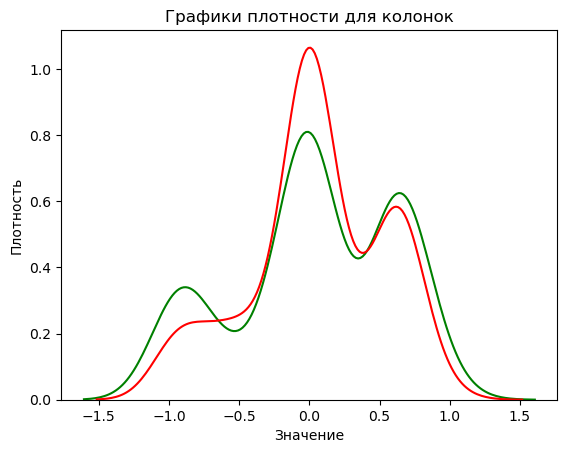

In [26]:
#Сравниваем GPT и HF распределение, зелёный гпт, красный человек
sns.kdeplot(data=df['sentiment_score_gpt'], label='sentiment_score_gpt 1', color='green')
sns.kdeplot(data=df['sentiment_HF'], label='sentiment_HF', color='red')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Графики плотности')
plt.show()

C:\Users\milai\AppData\Local\Temp\ipykernel_9564\551982022.py:2: UserWarning: 
The palette list has fewer values (2) than needed (36) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='sentiment_score_gpt', y='sentiment_HF', hue='sentiment_score_gpt', data=df, palette=['green', 'red'])


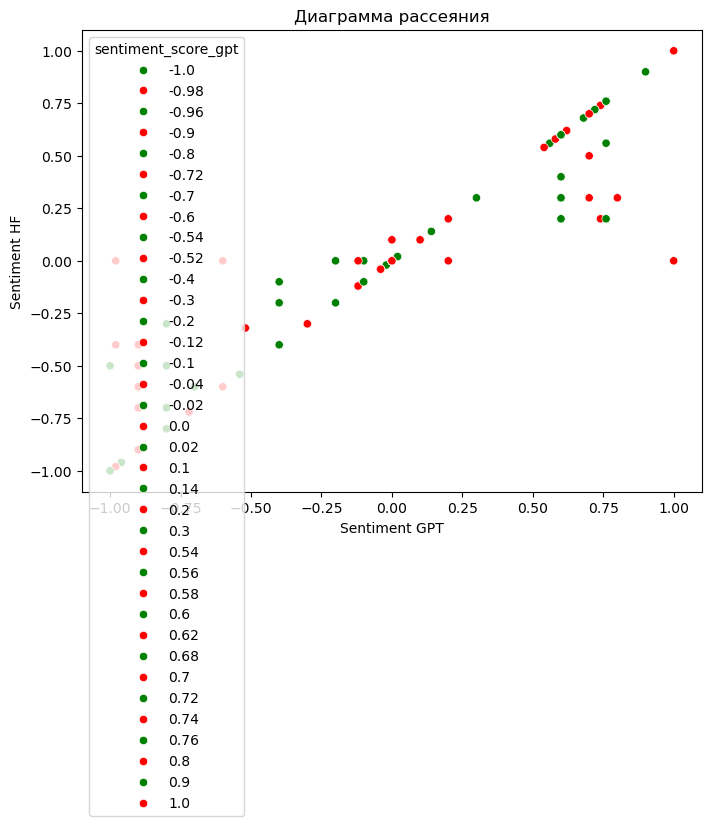

In [31]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='sentiment_score_gpt', y='sentiment_HF', hue='sentiment_score_gpt', data=df, palette=['green', 'red'])

plt.xlabel('Sentiment GPT')
plt.ylabel('Sentiment HF')
plt.title('Диаграмма рассеяния')

plt.show()

In [39]:
def predict(text, model, tokenizer, device):
  """
  Функция для предсказания модели BERT для заданного текста.

  Args:
      text: Текст для предсказания.
      model: Модель BERT (BertRegression).
      tokenizer: Токенизатор для BERT.
      device: Устройство для вычислений (CPU или GPU).

  Returns:
      Предсказанное непрерывное значение.
  """

  # Токенизация текста
  inputs = tokenizer_deep(text, return_tensors="pt", add_special_tokens=True, padding=True, max_length=512, truncation=True).to(device)
  torch.manual_seed(42)
  # Вывод модели
  with torch.no_grad():
    outputs = model(
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
    )

  # Получение предсказания
  output = outputs.squeeze().item()  # Извлекаем выход из последнего слоя (полносвязный)
  return output

In [47]:
df['sentiment_BERT'] = df['message'].apply(lambda text: predict(str(text), bert_regression_model, tokenizer_deep, device))

In [41]:
df

,message,timestamp,sentiment_level,sentiment_score_gpt,sentiment_HF,sentiment_BERT
0,sudo apt install postgresqlplpython\nя себе на...,2024-09-08 8:31:05,Neutral,0.70,0.30,-0.036224
1,sergeysavinovv,2024-09-07 12:13:38,Neutral,0.00,0.00,-0.042345
2,postgresql on x_pclinuxgnu compiled by gcc de...,2024-09-07 12:13:33,Neutral,0.00,0.00,-0.018385
3,какая версия postgresql,2024-09-07 9:09:05,Neutral,0.00,0.00,-0.018845
4,да,2024-09-05 15:02:36,Neutral,0.00,0.00,-0.039899
...,...,...,...,...,...,...
159,я ливаю нафиг,2024-09-03 10:24:40,Negative,-0.80,-0.70,-0.039463
160,я устал блин уже,2024-09-03 10:24:36,Mildly Negative,-0.04,-0.04,-0.036391
161,курс кал собачий,2024-09-03 10:22:31,Highly Negative,-0.80,-0.80,-0.041108
162,это какой то пиздец,2024-09-03 10:22:25,Highly Negative,-0.90,-0.90,-0.060875


In [48]:
df

,message,timestamp,sentiment_level,sentiment_score_gpt,sentiment_HF,sentiment_BERT
0,sudo apt install postgresqlplpython\nя себе на...,2024-09-08 8:31:05,Neutral,0.70,0.30,0.085124
1,sergeysavinovv,2024-09-07 12:13:38,Neutral,0.00,0.00,0.074022
2,postgresql on x_pclinuxgnu compiled by gcc de...,2024-09-07 12:13:33,Neutral,0.00,0.00,0.221937
3,какая версия postgresql,2024-09-07 9:09:05,Neutral,0.00,0.00,0.191022
4,да,2024-09-05 15:02:36,Neutral,0.00,0.00,-0.059888
...,...,...,...,...,...,...
159,я ливаю нафиг,2024-09-03 10:24:40,Negative,-0.80,-0.70,-0.342058
160,я устал блин уже,2024-09-03 10:24:36,Mildly Negative,-0.04,-0.04,-0.427517
161,курс кал собачий,2024-09-03 10:22:31,Highly Negative,-0.80,-0.80,-0.370822
162,это какой то пиздец,2024-09-03 10:22:25,Highly Negative,-0.90,-0.90,-0.680096


In [61]:
text = 'ты сука'
predict(text, bert_regression_model, tokenizer_deep, device)

-0.2780739665031433

In [49]:
df['sentiment_BERT'].describe()

count    164.000000
mean      -0.005732
std        0.350383
min       -0.994618
25%       -0.249323
50%        0.004642
75%        0.214975
max        0.817676
Name: sentiment_BERT, dtype: float64

In [64]:
df['sentiment_score_gpt'].describe()

count    164.000000
mean       0.039512
std        0.560223
min       -1.000000
25%       -0.140000
50%        0.000000
75%        0.600000
max        1.000000
Name: sentiment_score_gpt, dtype: float64

In [66]:
t_statistic, p_value = stats.ttest_ind(df['sentiment_BERT'], df['sentiment_score_gpt'])

print(f"t-статистика: {t_statistic:.4f}")
print(f"p-значение: {p_value:.4f}")

t-статистика: -0.8769
p-значение: 0.3812


In [58]:
rmse_GPT = sqrt(mean_squared_error(df['sentiment_HF'], df['sentiment_score_gpt']))
rmse_BERT = sqrt(mean_squared_error(df['sentiment_HF'], df['sentiment_BERT']))
mae_GPT = mean_absolute_error(df['sentiment_HF'], df['sentiment_score_gpt'])
mae_BERT =  mean_absolute_error(df['sentiment_HF'], df['sentiment_BERT'])
r2_GPT = r2_score(df['sentiment_HF'], df['sentiment_score_gpt'])
r2_BERT = r2_score(df['sentiment_HF'], df['sentiment_BERT'])
print(f"RMSE BERT: {rmse_BERT:.4f}")
print(f"RMSE GPT: {rmse_GPT:.4f}")
print(f"MAE BERT: {mae_BERT:.4f}")
print(f"MAE GPT: {mae_GPT:.4f}")
print(f"R2 BERT: {r2_BERT:.4f}")
print(f"R2 GPT: {r2_GPT:.4f}")

RMSE BERT: 0.4218
RMSE GPT: 0.1992
MAE BERT: 0.3332
MAE GPT: 0.0834
R2 BERT: 0.2121
R2 GPT: 0.8243


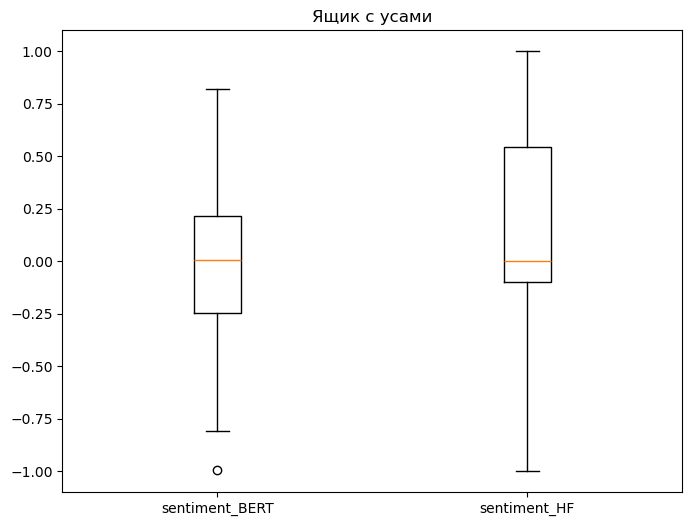

In [59]:
#Сравниваем GPT и HF распределение
plt.figure(figsize=(8, 6))
plt.boxplot([df['sentiment_BERT'], df['sentiment_HF']], labels=['sentiment_BERT', 'sentiment_HF'])
plt.title('Ящик с усами')
plt.show()

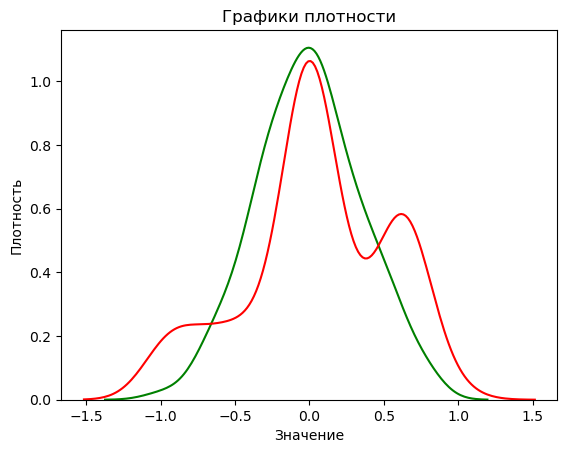

In [60]:
#Сравниваем GPT и HF распределение, зелёный берт, красный человек
sns.kdeplot(data=df['sentiment_BERT'], label='sentiment_BERT', color='green')
sns.kdeplot(data=df['sentiment_HF'], label='sentiment_HF', color='red')
plt.xlabel('Значение')
plt.ylabel('Плотность')
plt.title('Графики плотности')
plt.show()